<a href="https://colab.research.google.com/github/x18134301/x18134301_TusharDalvi/blob/master/pneumonia_Classification_using_VGG19.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import os
import cv2
import numpy as np
import random
from PIL import Image
from PIL import ImageOps
import pandas as pd 
import tensorflow as tf
from tensorflow.keras import layers, models
import matplotlib.pyplot as plt
from pathlib import Path
from sklearn.metrics import confusion_matrix
from mlxtend.plotting import plot_confusion_matrix
from google.colab import drive
import seaborn as sns
import matplotlib.image as mimg
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


Setting Seed and checking directory

In [0]:
np.random.seed(1000)
#new layers end here
print(os.listdir("/content/gdrive/My Drive/chest_xray"))

['val', 'test', 'train', '.DS_Store']


lets check the Data

#Need to explore data

In [0]:
# Define path to the data directory
data_dir = Path('/content/gdrive/My Drive/chest_xray')

# Path to train directory (Fancy pathlib...no more os.path!!)
train_dir = data_dir / 'train'

# Path to validation directory
val_dir = data_dir / 'val'

# Path to test directory
test_dir = data_dir / 'test'

#                                                Trainning Data Count

In [0]:
#PNEUMONIA: This directory contains those samples that are the pneumonia cases.
# Get the path to the normal and pneumonia sub-directories
normal_cases_dir = train_dir / 'NORMAL'
pneumonia_cases_dir = train_dir / 'PNEUMONIA'

# Get the list of all the images
normal_cases = normal_cases_dir.glob('*.jpeg')
pneumonia_cases = pneumonia_cases_dir.glob('*.jpeg')

# An empty list. We will insert the data into this list in (img_path, label) format
train_data = []

# Go through all the normal cases. The label for these cases will be 0
for img in normal_cases:
    train_data.append((img,0))

# Go through all the pneumonia cases. The label for these cases will be 1
for img in pneumonia_cases:
    train_data.append((img, 1))

# Get a pandas dataframe from the data we have in our list 
train_data = pd.DataFrame(train_data, columns=['image', 'label'],index=None)

# Shuffle the data 
train_data = train_data.sample(frac=1.).reset_index(drop=True)

# How the dataframe looks like?
train_data.head()

,image,label
0,/content/gdrive/My Drive/chest_xray/train/NORM...,0
1,/content/gdrive/My Drive/chest_xray/train/PNEU...,1
2,/content/gdrive/My Drive/chest_xray/train/NORM...,0
3,/content/gdrive/My Drive/chest_xray/train/PNEU...,1
4,/content/gdrive/My Drive/chest_xray/train/NORM...,0


#Trainning Data Count Graph

1    3875
0    1341
Name: label, dtype: int64


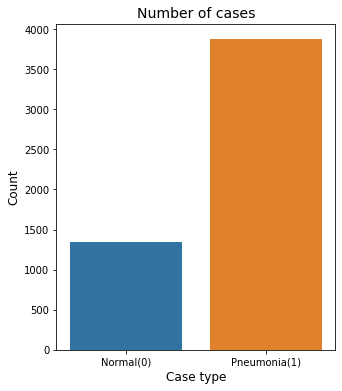

In [0]:
# Get the counts for each class
cases_count = train_data['label'].value_counts()
print(cases_count)

# Plot the results 
plt.figure(figsize=(5,6))
sns.barplot(x=cases_count.index, y= cases_count.values)
plt.title('Number of cases', fontsize=14)
plt.xlabel('Case type', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.xticks(range(len(cases_count.index)), ['Normal(0)', 'Pneumonia(1)'])
plt.show()

Lets See Some Images From Trainning Data

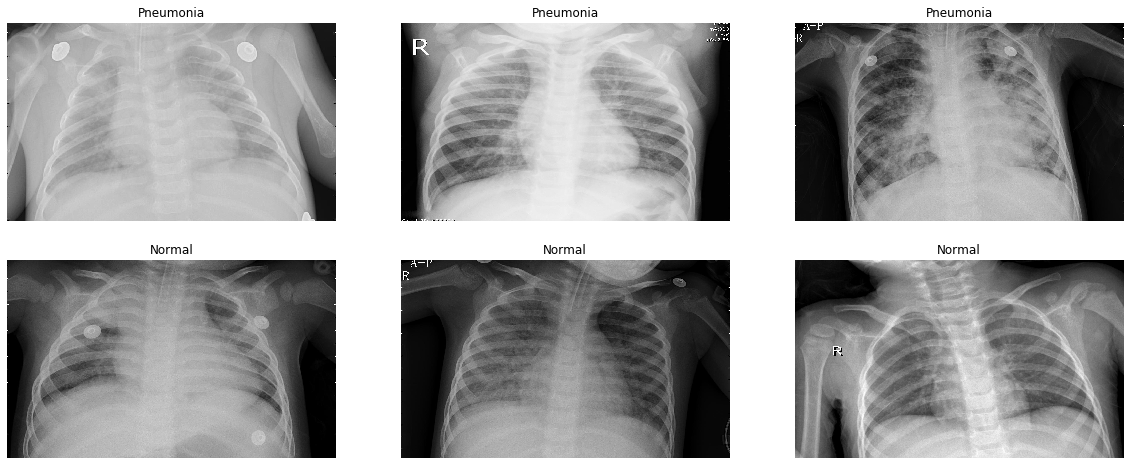

In [0]:
from skimage.io import imread
from skimage.transform import resize


# Get few samples for both the classes
pneumonia_samples = (train_data[train_data['label']==1]['image'].iloc[:5]).tolist()
normal_samples = (train_data[train_data['label']==0]['image'].iloc[:5]).tolist()

# Concat the data in a single list and del the above two list
samples = pneumonia_samples + normal_samples
del pneumonia_samples, normal_samples

# Plot the data 
f, ax = plt.subplots(2,3, figsize=(20,8))
for i in range(6):
    img = imread(samples[i])
    ax[i//3, i%3].imshow(img, cmap='gray')
    if i<3:
        ax[i//3, i%3].set_title("Pneumonia")
    else:
        ax[i//3, i%3].set_title("Normal")
    ax[i//3, i%3].axis('off')
    ax[i//3, i%3].set_aspect('auto')
plt.show()

#Testing Data Count

In [0]:
#PNEUMONIA: This directory contains those samples that are the pneumonia cases.
# Get the path to the normal and pneumonia sub-directories
normal_test_cases_dir = test_dir / 'NORMAL'
pneumonia_test_cases_dir = test_dir / 'PNEUMONIA'

# Get the list of all the images
test_normal_cases = normal_test_cases_dir.glob('*.jpeg')
test_pneumonia_cases = pneumonia_test_cases_dir.glob('*.jpeg')

# An empty list. We will insert the data into this list in (img_path, label) format
test_data = []

# Go through all the normal cases. The label for these cases will be 0
for img in test_normal_cases:
    test_data.append((img,0))

# Go through all the pneumonia cases. The label for these cases will be 1
for img in test_pneumonia_cases:
    test_data.append((img, 1))

# Get a pandas dataframe from the data we have in our list 
test_data = pd.DataFrame(test_data, columns=['image', 'label'],index=None)

# Shuffle the data 
test_data = test_data.sample(frac=1.).reset_index(drop=True)

# How the dataframe looks like?
test_data.head()

,image,label
0,/content/gdrive/My Drive/chest_xray/test/PNEUM...,1
1,/content/gdrive/My Drive/chest_xray/test/PNEUM...,1
2,/content/gdrive/My Drive/chest_xray/test/PNEUM...,1
3,/content/gdrive/My Drive/chest_xray/test/NORMA...,0
4,/content/gdrive/My Drive/chest_xray/test/PNEUM...,1


#Testing Data Count Graph

1    390
0    234
Name: label, dtype: int64


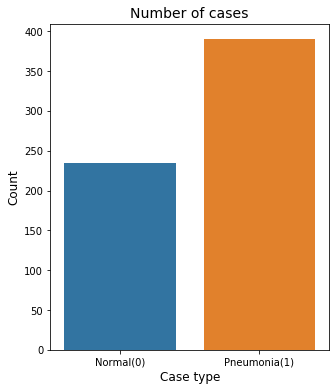

In [0]:
# Get the counts for each class
test_cases_count = test_data['label'].value_counts()
print(test_cases_count)

# Plot the results 
plt.figure(figsize=(5,6))
sns.barplot(x=test_cases_count.index, y= test_cases_count.values)
plt.title('Number of cases', fontsize=14)
plt.xlabel('Case type', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.xticks(range(len(test_cases_count.index)), ['Normal(0)', 'Pneumonia(1)'])
plt.show()

Making Data Ready for Model

In [0]:
# Load and augment training data
train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1/255, 
    rotation_range=20, 
    width_shift_range=0.2, 
    height_shift_range=0.2, 
    horizontal_flip=True
)

train_generator = train_datagen.flow_from_directory(
    '/content/gdrive/My Drive/chest_xray/train',
    batch_size=16,
    target_size=(128, 128),
    shuffle=True,
    class_mode='categorical'
)

Found 5216 images belonging to 2 classes.


In [0]:
# Load validation and test data
val_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1/255)
val_generator = val_datagen.flow_from_directory(
    '/content/gdrive/My Drive/chest_xray/val',
    batch_size=16,
    target_size=(128, 128),
    class_mode='categorical'
)

test_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1/255)
test_generator = test_datagen.flow_from_directory(
    '/content/gdrive/My Drive/chest_xray/test',
    batch_size=16,
    target_size=(128, 128),
    class_mode='categorical'
)

Found 16 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


Building Model

In [0]:
# Use MobileNetV2 as base model for transfer learning
base_model = tf.keras.applications.VGG19(
    weights='imagenet',
    include_top=False,
    input_shape=(128, 128, 3)
)
base_model.trainable = False

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
80142336/80134624 [==============================] - 2s 0us/step


Adding Few More Layers

In [0]:
# Define model
def model():
    model = base_model.output
    model = tf.keras.layers.GlobalAveragePooling2D()(model)
    model = tf.keras.layers.Dense(units=512, activation='relu')(model)
    model = tf.keras.layers.Dropout(0.7)(model)
    predictions = tf.keras.layers.Dense(units=2, activation='softmax')(model)
    model = tf.keras.models.Model(inputs=base_model.input, outputs=predictions)
    return model

In [0]:
model = model()
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [0]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 128, 128, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 128, 128, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 128, 128, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 64, 64, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 64, 64, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 64, 64, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 32, 32, 128)       0     

In [0]:
#from keras.utils.vis_utils import plot_model
from tensorflow.keras.utils import plot_model

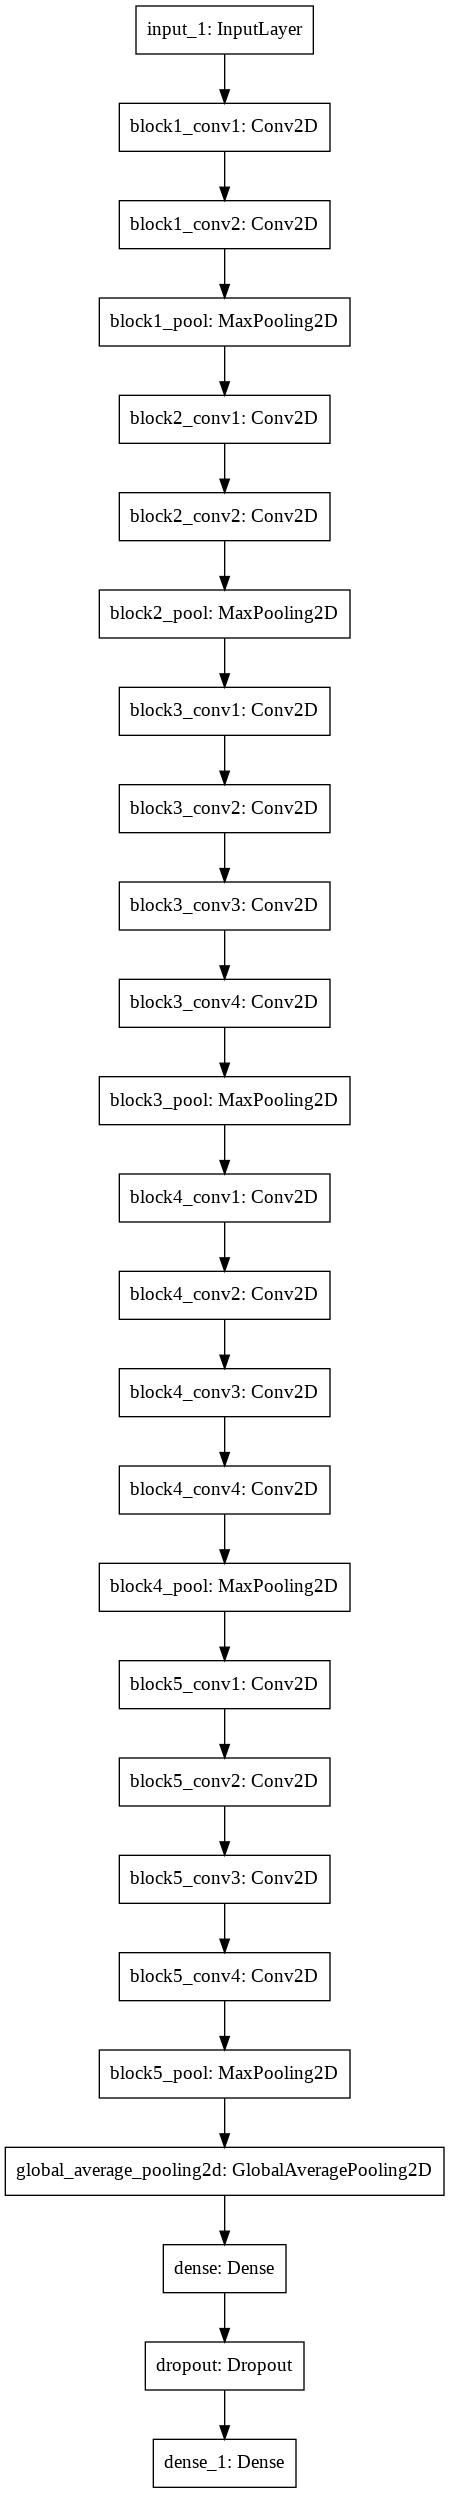

In [0]:
plot_model(model, to_file='VGG.png')

Trainning Model

In [0]:
Log = model.fit_generator(
    train_generator,
    epochs=20,
    verbose=1,
    validation_data=val_generator,
)

Epoch 1/20
326/326 [==============================] - 2526s 8s/step - loss: 0.3527 - acc: 0.8359 - val_loss: 0.5513 - val_acc: 0.7500
Epoch 2/20
326/326 [==============================] - 762s 2s/step - loss: 0.2649 - acc: 0.8909 - val_loss: 0.5838 - val_acc: 0.8125
Epoch 3/20
326/326 [==============================] - 769s 2s/step - loss: 0.2448 - acc: 0.8982 - val_loss: 0.4172 - val_acc: 0.7500
Epoch 4/20
326/326 [==============================] - 765s 2s/step - loss: 0.2271 - acc: 0.9045 - val_loss: 0.4351 - val_acc: 0.7500
Epoch 5/20
326/326 [==============================] - 764s 2s/step - loss: 0.2216 - acc: 0.9080 - val_loss: 0.5235 - val_acc: 0.8125
Epoch 6/20
326/326 [==============================] - 764s 2s/step - loss: 0.2053 - acc: 0.9164 - val_loss: 0.5632 - val_acc: 0.8125
Epoch 7/20
326/326 [==============================] - 765s 2s/step - loss: 0.2150 - acc: 0.9122 - val_loss: 0.5969 - val_acc: 0.8125
Epoch 8/20
326/326 [==============================] - 765s 2s/step -

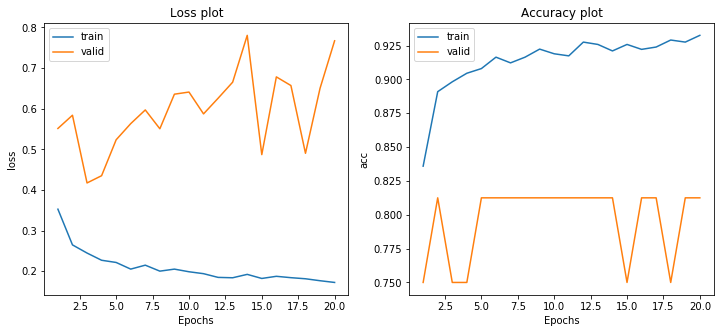

In [0]:
# plot the model loss and accuracy
train_loss = Log.history['loss']
train_acc = Log.history['acc']

valid_loss = Log.history['val_loss']
valid_acc = Log.history['val_acc']

x = [(i+1) for i in range(len(train_loss))]

f,ax = plt.subplots(1,2, figsize=(12,5))
ax[0].plot(x, train_loss)
ax[0].plot(x, valid_loss)
ax[0].set_title("Loss plot")
ax[0].set_xlabel("Epochs")
ax[0].set_ylabel("loss")
ax[0].legend(['train', 'valid'])


ax[1].plot(x, train_acc)
ax[1].plot(x, valid_acc)
ax[1].set_title("Accuracy plot")
ax[1].set_xlabel("Epochs")
ax[1].set_ylabel("acc")
ax[1].legend(['train', 'valid'])

plt.show()

In [0]:
loss, test_acc = model.evaluate_generator(
    test_generator,
    steps=None,
    max_queue_size=10,
    workers=1,
    use_multiprocessing=True,
    verbose=1
)

print(test_acc)

39/39 [==============================] - 324s 8s/step - loss: 0.4148 - acc: 0.8638
0.86378205


In [0]:
model.save('model.h5')

In [0]:
# Load model for testing
model = tf.keras.models.load_model('model.h5')

test_dir = Path('/content/gdrive/My Drive/chest_xray/test')

normal_cases_dir = test_dir / 'NORMAL'
pneumonia_cases_dir = test_dir / 'PNEUMONIA'

normal_cases = normal_cases_dir.glob('*.jpeg')
pneumonia_cases = pneumonia_cases_dir.glob('*.jpeg')

test_data = []
test_labels = []

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


In [0]:

for img in normal_cases:
    img = cv2.imread(str(img))
    img = cv2.resize(img, (128, 128))
    if img.shape[2] == 1:
        img = np.dstack([img, img, img])
    else:
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = img.astype(np.float32)/255.
    label = tf.keras.utils.to_categorical(0, num_classes=2)
    test_data.append(img)
    test_labels.append(label)

for img in pneumonia_cases:
    img = cv2.imread(str(img))
    img = cv2.resize(img, (128, 128))
    if img.shape[2] == 1:
        img = np.dstack([img, img, img])
    else:
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = img.astype(np.float32)/255.
    label = tf.keras.utils.to_categorical(1, num_classes=2)
    test_data.append(img)
    test_labels.append(label)

test_data = np.array(test_data)
test_labels = np.array(test_labels)

print("Total number of test examples: ", test_data.shape)
print("Total number of labels:", test_labels.shape)

Total number of test examples:  (624, 128, 128, 3)
Total number of labels: (624, 2)


<Figure size 432x288 with 0 Axes>

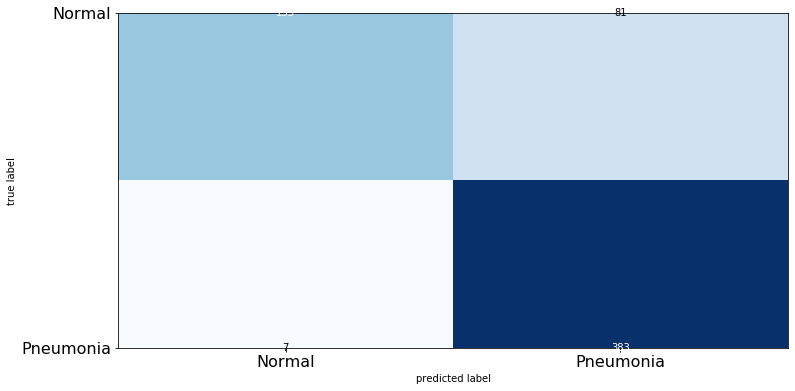

Recall of the model is 0.98
Precision of the model is 0.83


In [0]:
# Get predictions
preds = model.predict(test_data, batch_size=16)#<-
preds = np.argmax(preds, axis=-1)

# Original labels
orig_test_labels = np.argmax(test_labels, axis=-1)

cm = confusion_matrix(orig_test_labels, preds)
plt.figure()
plot_confusion_matrix(cm, figsize=(12, 8), hide_ticks=True,
                      cmap=plt.cm.Blues)
plt.xticks(range(2), ['Normal', 'Pneumonia'], fontsize=16)
plt.yticks(range(2), ['Normal', 'Pneumonia'], fontsize=16)
plt.show()

tn, fp, fn, tp = cm.ravel()

precision = tp/(tp+fp)
recall = tp/(tp+fn)

print("Recall of the model is {:.2f}".format(recall))
print("Precision of the model is {:.2f}".format(precision))